In [106]:
from typing import Any, Dict, Literal, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import sidetable as stb
from catboost import CatBoostClassifier
from sklearn.metrics import (PrecisionRecallDisplay, RocCurveDisplay,
                             classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, recall_score)
from sklearn.model_selection import (RepeatedStratifiedKFold, StratifiedKFold,
                                     train_test_split)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
import shap

In [107]:
def remove_outliers_iqr_multi(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Remove outliers from multiple columns in a DataFrame using the IQR method.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    cols : list of str
        List of column names to clean.

    Returns
    -------
    pd.DataFrame
        DataFrame with outliers removed.

    Examples
    --------
    >>> df_filtered = remove_outliers_iqr_multi(df, ['col1', 'col2'])
    """
    mask = pd.Series(True, index=df.index)
    for col in cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask &= df[col].between(lower, upper)
    return df[mask]


def add_engineered_features(df: pd.DataFrame, inplace: bool = False) -> pd.DataFrame:
    """
    Add engineered features for GBDT models to a copy of the input DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Original Bank Marketing DataFrame.
    inplace : bool, optional
        If True, modify the input df in-place. If False (default), return modified copy.

    Returns
    -------
    pd.DataFrame
        DataFrame with added features.
    """
    if not inplace:
        df = df.copy()

    # === Age binning ===
    df["age_group"] = pd.cut(
        df["age"],
        bins=[0, 30, 55, np.inf],  # cover all realistic ages
        labels=["young", "middle", "senior"],
        include_lowest=True,
    )

    # === Education × Marital cross-feature ===
    df["education_marital"] = (
        df["education"].astype(str) + "_" + df["marital_status"].astype(str)
    )

    # === Interest spread: CPI - Euribor ===
    df["interest_diff"] = df["cons_price_index"] - df["euri_3_month"]

    # === Month + weekday combined ===
    df["month_weekday"] = df["month"].astype(str) + "_" + df["week_day"].astype(str)

    # === Interest pressure ratio ===
    df["interest_pressure_ratio"] = df["cons_price_index"] / (df["euri_3_month"] + 1e-3)

    # === Log features (avoid skew) ===
    df["log_duration"] = np.log1p(df["last_contact_duration"])

    # === Month → Season mapping ===
    month_to_season = {
        "mar": "spring",
        "apr": "spring",
        "may": "spring",
        "jun": "summer",
        "jul": "summer",
        "aug": "summer",
        "sep": "autumn",
        "oct": "autumn",
        "nov": "autumn",
        "dec": "winter",
        "jan": "winter",
        "feb": "winter",
    }
    df["season"] = df["month"].map(month_to_season)

    # === Loan burden score ===
    df["loan_burden_score"] = (df["housing_loan"] == "yes").astype(int) + (
        df["personal_loan"] == "yes"
    ).astype(int)

    # === Volatility index ===
    df["volatility_score"] = (
        df["emp_var_rate"].abs()
        + df["cons_conf_index"].abs()
        + df["euri_3_month"].abs()
    )

    return df


def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    val_size: float = 0.1,
    test_size: float = 0.1,
    random_state: int = 42,
    use_stratification: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Split input data into train, validation, and test sets, optionally using stratification.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    val_size : float, optional
        Proportion of the data to include in the validation set, by default 0.1.
    test_size : float, optional
        Proportion of the data to include in the test set, by default 0.1.
    random_state : int, optional
        Random seed for reproducible splits, by default 42.
    use_stratification : bool, optional
        If True, data splits will be stratified using the target variable. By default False.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]
        A tuple containing:
        - X_train: pd.DataFrame
            Training feature matrix
        - X_val: pd.DataFrame
            Validation feature matrix
        - X_test: pd.DataFrame
            Test feature matrix
        - y_train: pd.Series
            Training target vector
        - y_val: pd.Series
            Validation target vector
        - y_test: pd.Series
            Test target vector

    Raises
    ------
    ValueError
        If the sum of val_size and test_size is greater than or equal to 1.
    """
    # Check that the requested splits are valid
    if val_size + test_size >= 1:
        raise ValueError("val_size + test_size must be less than 1.")

    # Determine stratification parameters
    stratify_test = y if use_stratification else None

    # First split off the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_test,  # stratify if specified
    )

    # Adjust val_size proportion relative to the remaining data after removing test
    adjusted_val_size = val_size / (1 - test_size)

    # For the second split (train/val), stratify on the reduced dataset if needed
    stratify_val = y_temp if use_stratification else None

    # Split the remaining data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=adjusted_val_size,
        random_state=random_state,
        stratify=stratify_val,  # stratify if specified
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [108]:
df = pd.read_csv("bank_dataset (3) (1) (1) (3) (1) (2) (1) (1) (1).csv")

In [156]:
df.head()

,age,occupation,marital_status,education,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,...,euri_3_month,age_group,education_marital,interest_diff,month_weekday,interest_pressure_ratio,log_duration,season,loan_burden_score,volatility_score
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,...,4.857,senior,basic.4y_married,89.137,may_mon,19.348291,5.568345,spring,0,42.357
1,57,services,married,high.school,no,no,telephone,may,mon,149,...,4.857,senior,high.school_married,89.137,may_mon,19.348291,5.010635,spring,0,42.357
2,37,services,married,high.school,yes,no,telephone,may,mon,226,...,4.857,middle,high.school_married,89.137,may_mon,19.348291,5.424950,spring,1,42.357
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,...,4.857,middle,basic.6y_married,89.137,may_mon,19.348291,5.023881,spring,0,42.357
4,56,services,married,high.school,no,yes,telephone,may,mon,307,...,4.857,senior,high.school_married,89.137,may_mon,19.348291,5.730100,spring,1,42.357


### EDA

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    41188 non-null  int64  
 1   occupation             41188 non-null  object 
 2   marital_status         41188 non-null  object 
 3   education              41188 non-null  object 
 4   has_credit             41188 non-null  object 
 5   housing_loan           41188 non-null  object 
 6   personal_loan          41188 non-null  object 
 7   contact_mode           41188 non-null  object 
 8   month                  41188 non-null  object 
 9   week_day               41188 non-null  object 
 10  last_contact_duration  41188 non-null  int64  
 11  contacts_per_campaign  41188 non-null  int64  
 12  N_last_days            41188 non-null  int64  
 13  nb_previous_contact    41188 non-null  int64  
 14  previous_outcome       41188 non-null  object 
 15  em

In [111]:
df.stb.missing(style=True)

,missing,total,percent
age,0,"41,188",0.00%
contacts_per_campaign,0,"41,188",0.00%
nb_employees,0,"41,188",0.00%
euri_3_month,0,"41,188",0.00%
cons_conf_index,0,"41,188",0.00%
cons_price_index,0,"41,188",0.00%
emp_var_rate,0,"41,188",0.00%
previous_outcome,0,"41,188",0.00%
nb_previous_contact,0,"41,188",0.00%
N_last_days,0,"41,188",0.00%


In [112]:
df.stb.freq(["target"], style=True)

,target,count,percent,cumulative_count,cumulative_percent
0,no,"36,548",88.73%,"36,548",88.73%
1,yes,"4,640",11.27%,"41,188",100.00%


In [113]:
df.stb.freq(["occupation", "marital_status"], style=True)

,occupation,marital_status,count,percent,cumulative_count,cumulative_percent
0,blue-collar,married,"6,687",16.24%,"6,687",16.24%
1,admin.,married,"5,253",12.75%,"11,940",28.99%
2,admin.,single,"3,875",9.41%,"15,815",38.40%
3,technician,married,"3,670",8.91%,"19,485",47.31%
4,services,married,"2,294",5.57%,"21,779",52.88%
5,technician,single,"2,287",5.55%,"24,066",58.43%
6,management,married,"2,089",5.07%,"26,155",63.50%
7,blue-collar,single,"1,825",4.43%,"27,980",67.93%
8,admin.,divorced,"1,280",3.11%,"29,260",71.04%
9,retired,married,"1,274",3.09%,"30,534",74.13%


In [114]:
df.stb.freq(["education"], style=True)

,education,count,percent,cumulative_count,cumulative_percent
0,university.degree,"12,168",29.54%,"12,168",29.54%
1,high.school,"9,515",23.10%,"21,683",52.64%
2,basic.9y,"6,045",14.68%,"27,728",67.32%
3,professional.course,"5,243",12.73%,"32,971",80.05%
4,basic.4y,"4,176",10.14%,"37,147",90.19%
5,basic.6y,"2,292",5.56%,"39,439",95.75%
6,unknown,"1,731",4.20%,"41,170",99.96%
7,illiterate,18,0.04%,"41,188",100.00%


In [115]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
target,41188,2,no,36548,yes,4640
contact_mode,41188,2,cellular,26144,telephone,15044
has_credit,41188,3,no,32588,yes,3
housing_loan,41188,3,yes,21576,unknown,990
personal_loan,41188,3,no,33950,unknown,990
previous_outcome,41188,3,nonexistent,35563,success,1373
marital_status,41188,4,married,24928,unknown,80
week_day,41188,5,thu,8623,fri,7827
education,41188,8,university.degree,12168,illiterate,18
nb_previous_contact,41188,8,0,35563,7,1


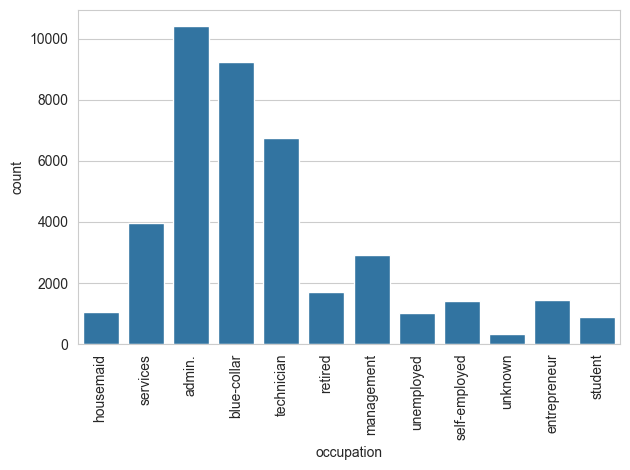

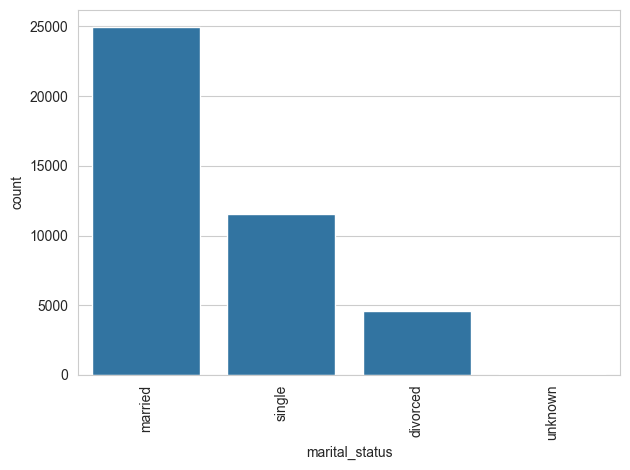

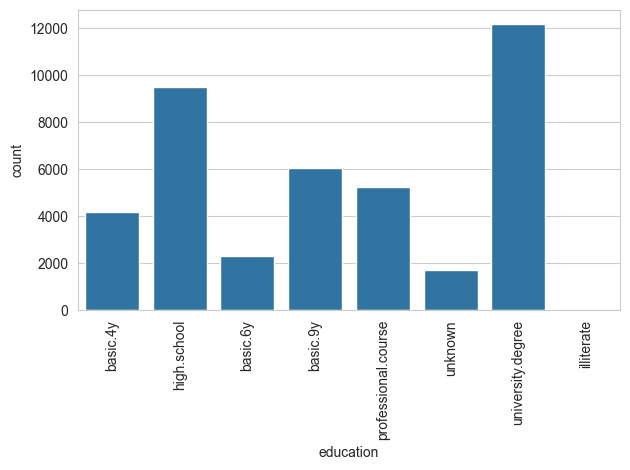

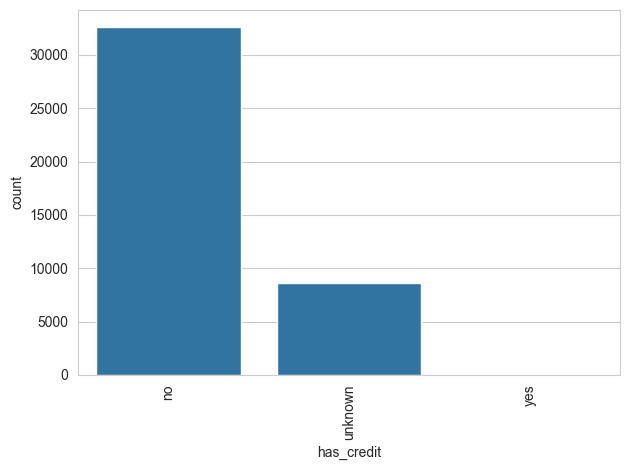

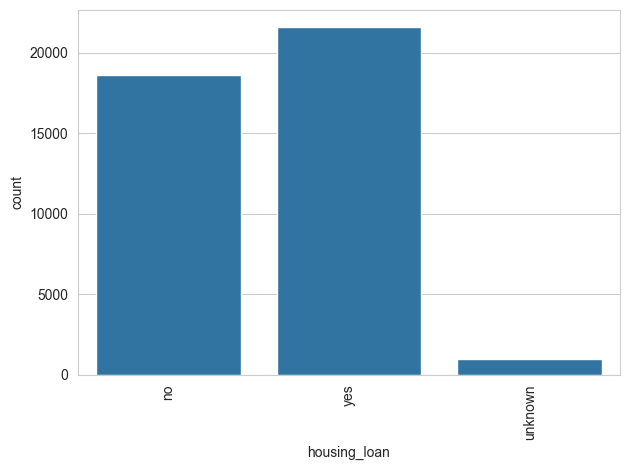

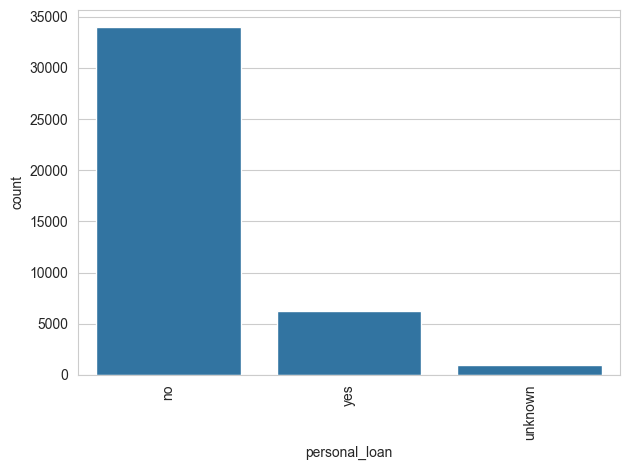

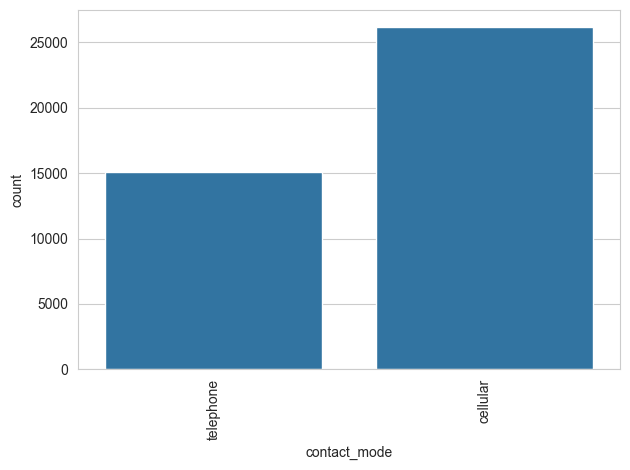

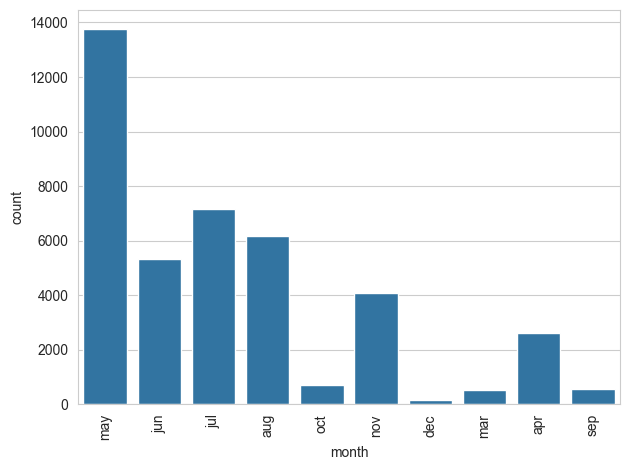

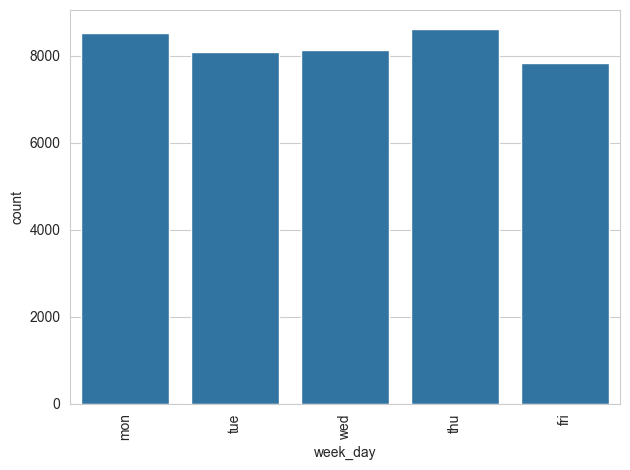

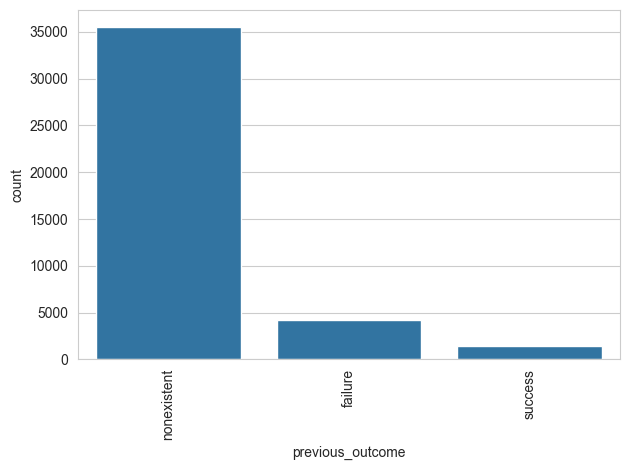

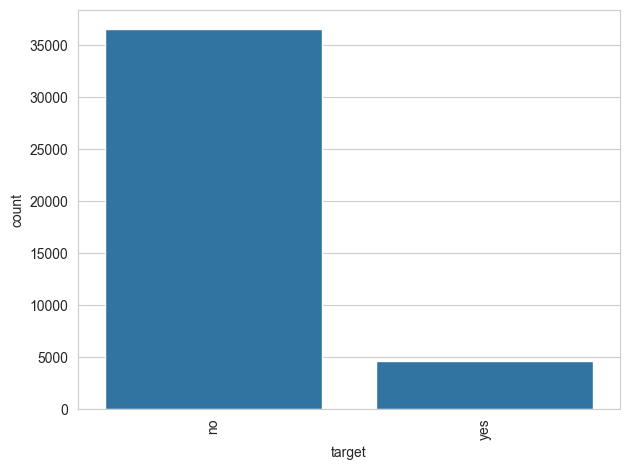

In [116]:
for col in df.select_dtypes(include=["object"]).columns:
    sns.countplot(x=col, data=df)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

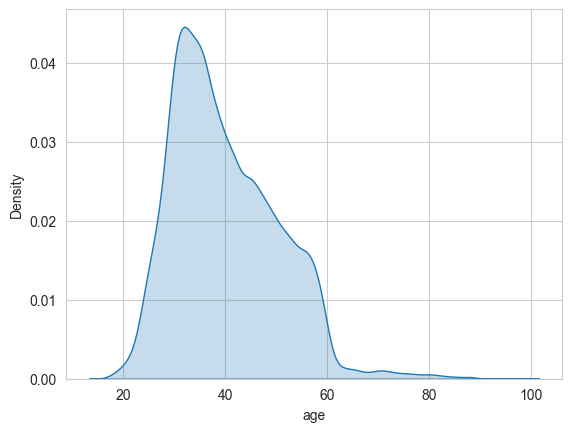

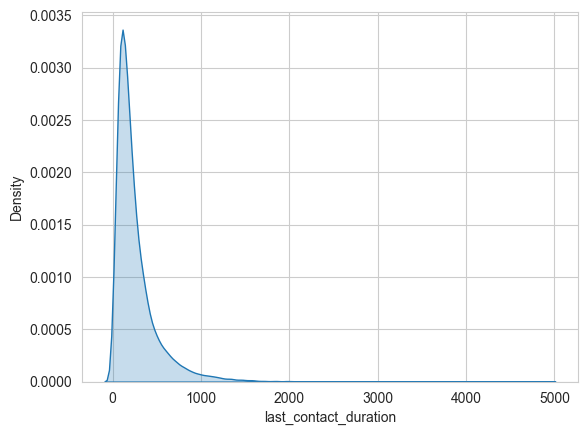

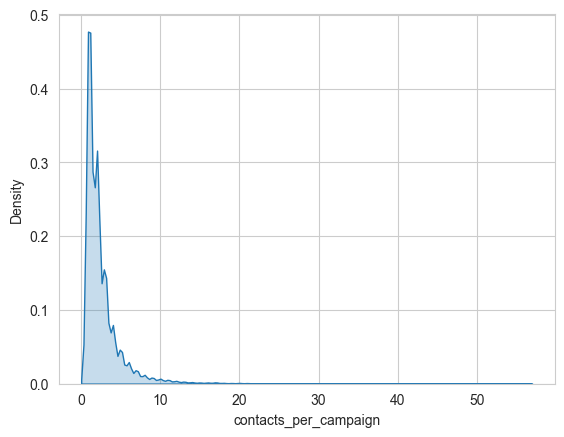

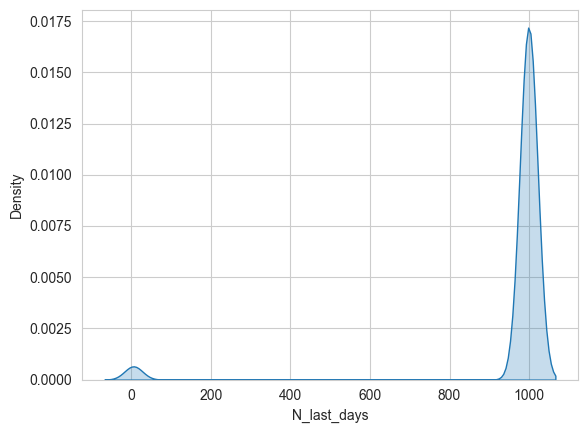

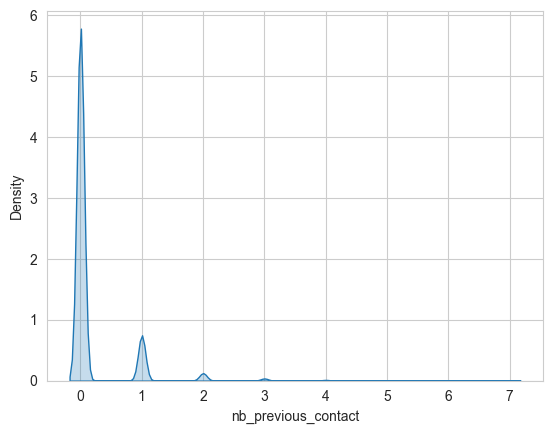

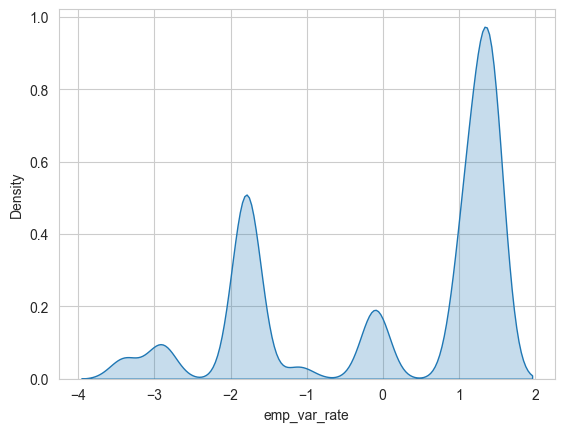

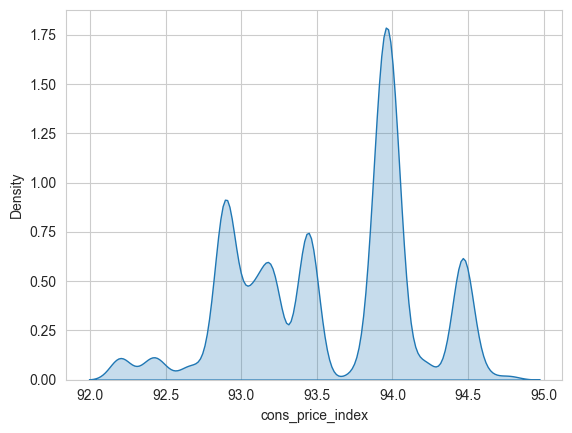

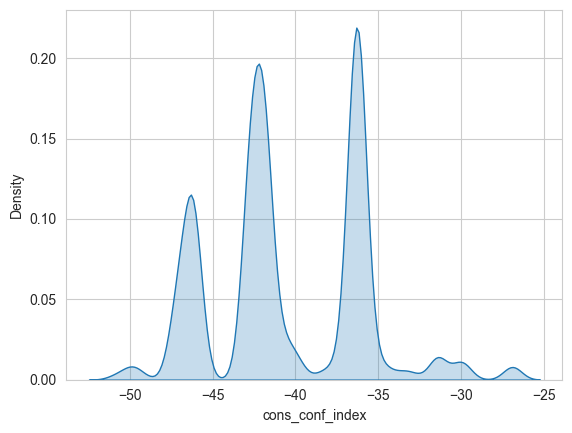

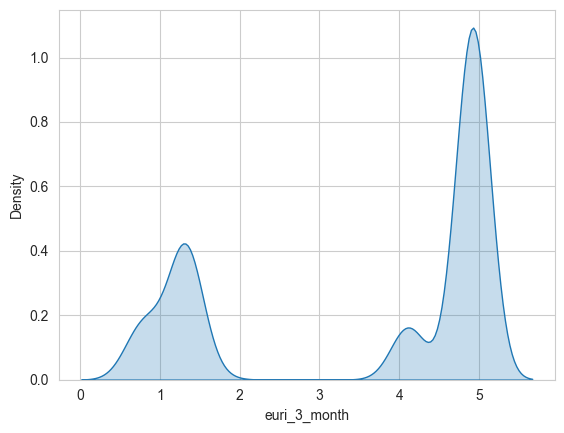

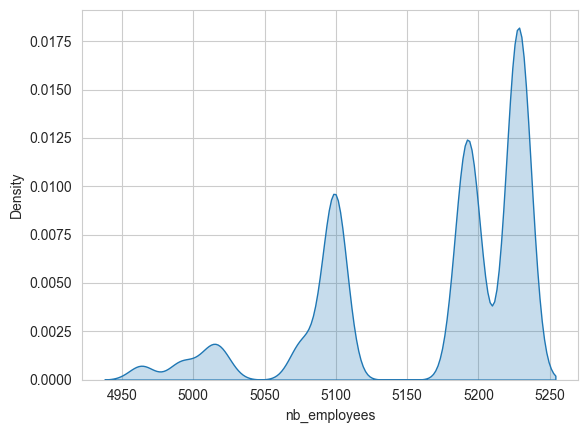

In [117]:
for col in df.select_dtypes(include=["int64", "float64"]).columns:
    sns.kdeplot(x=df[col], fill=True)
    plt.show()

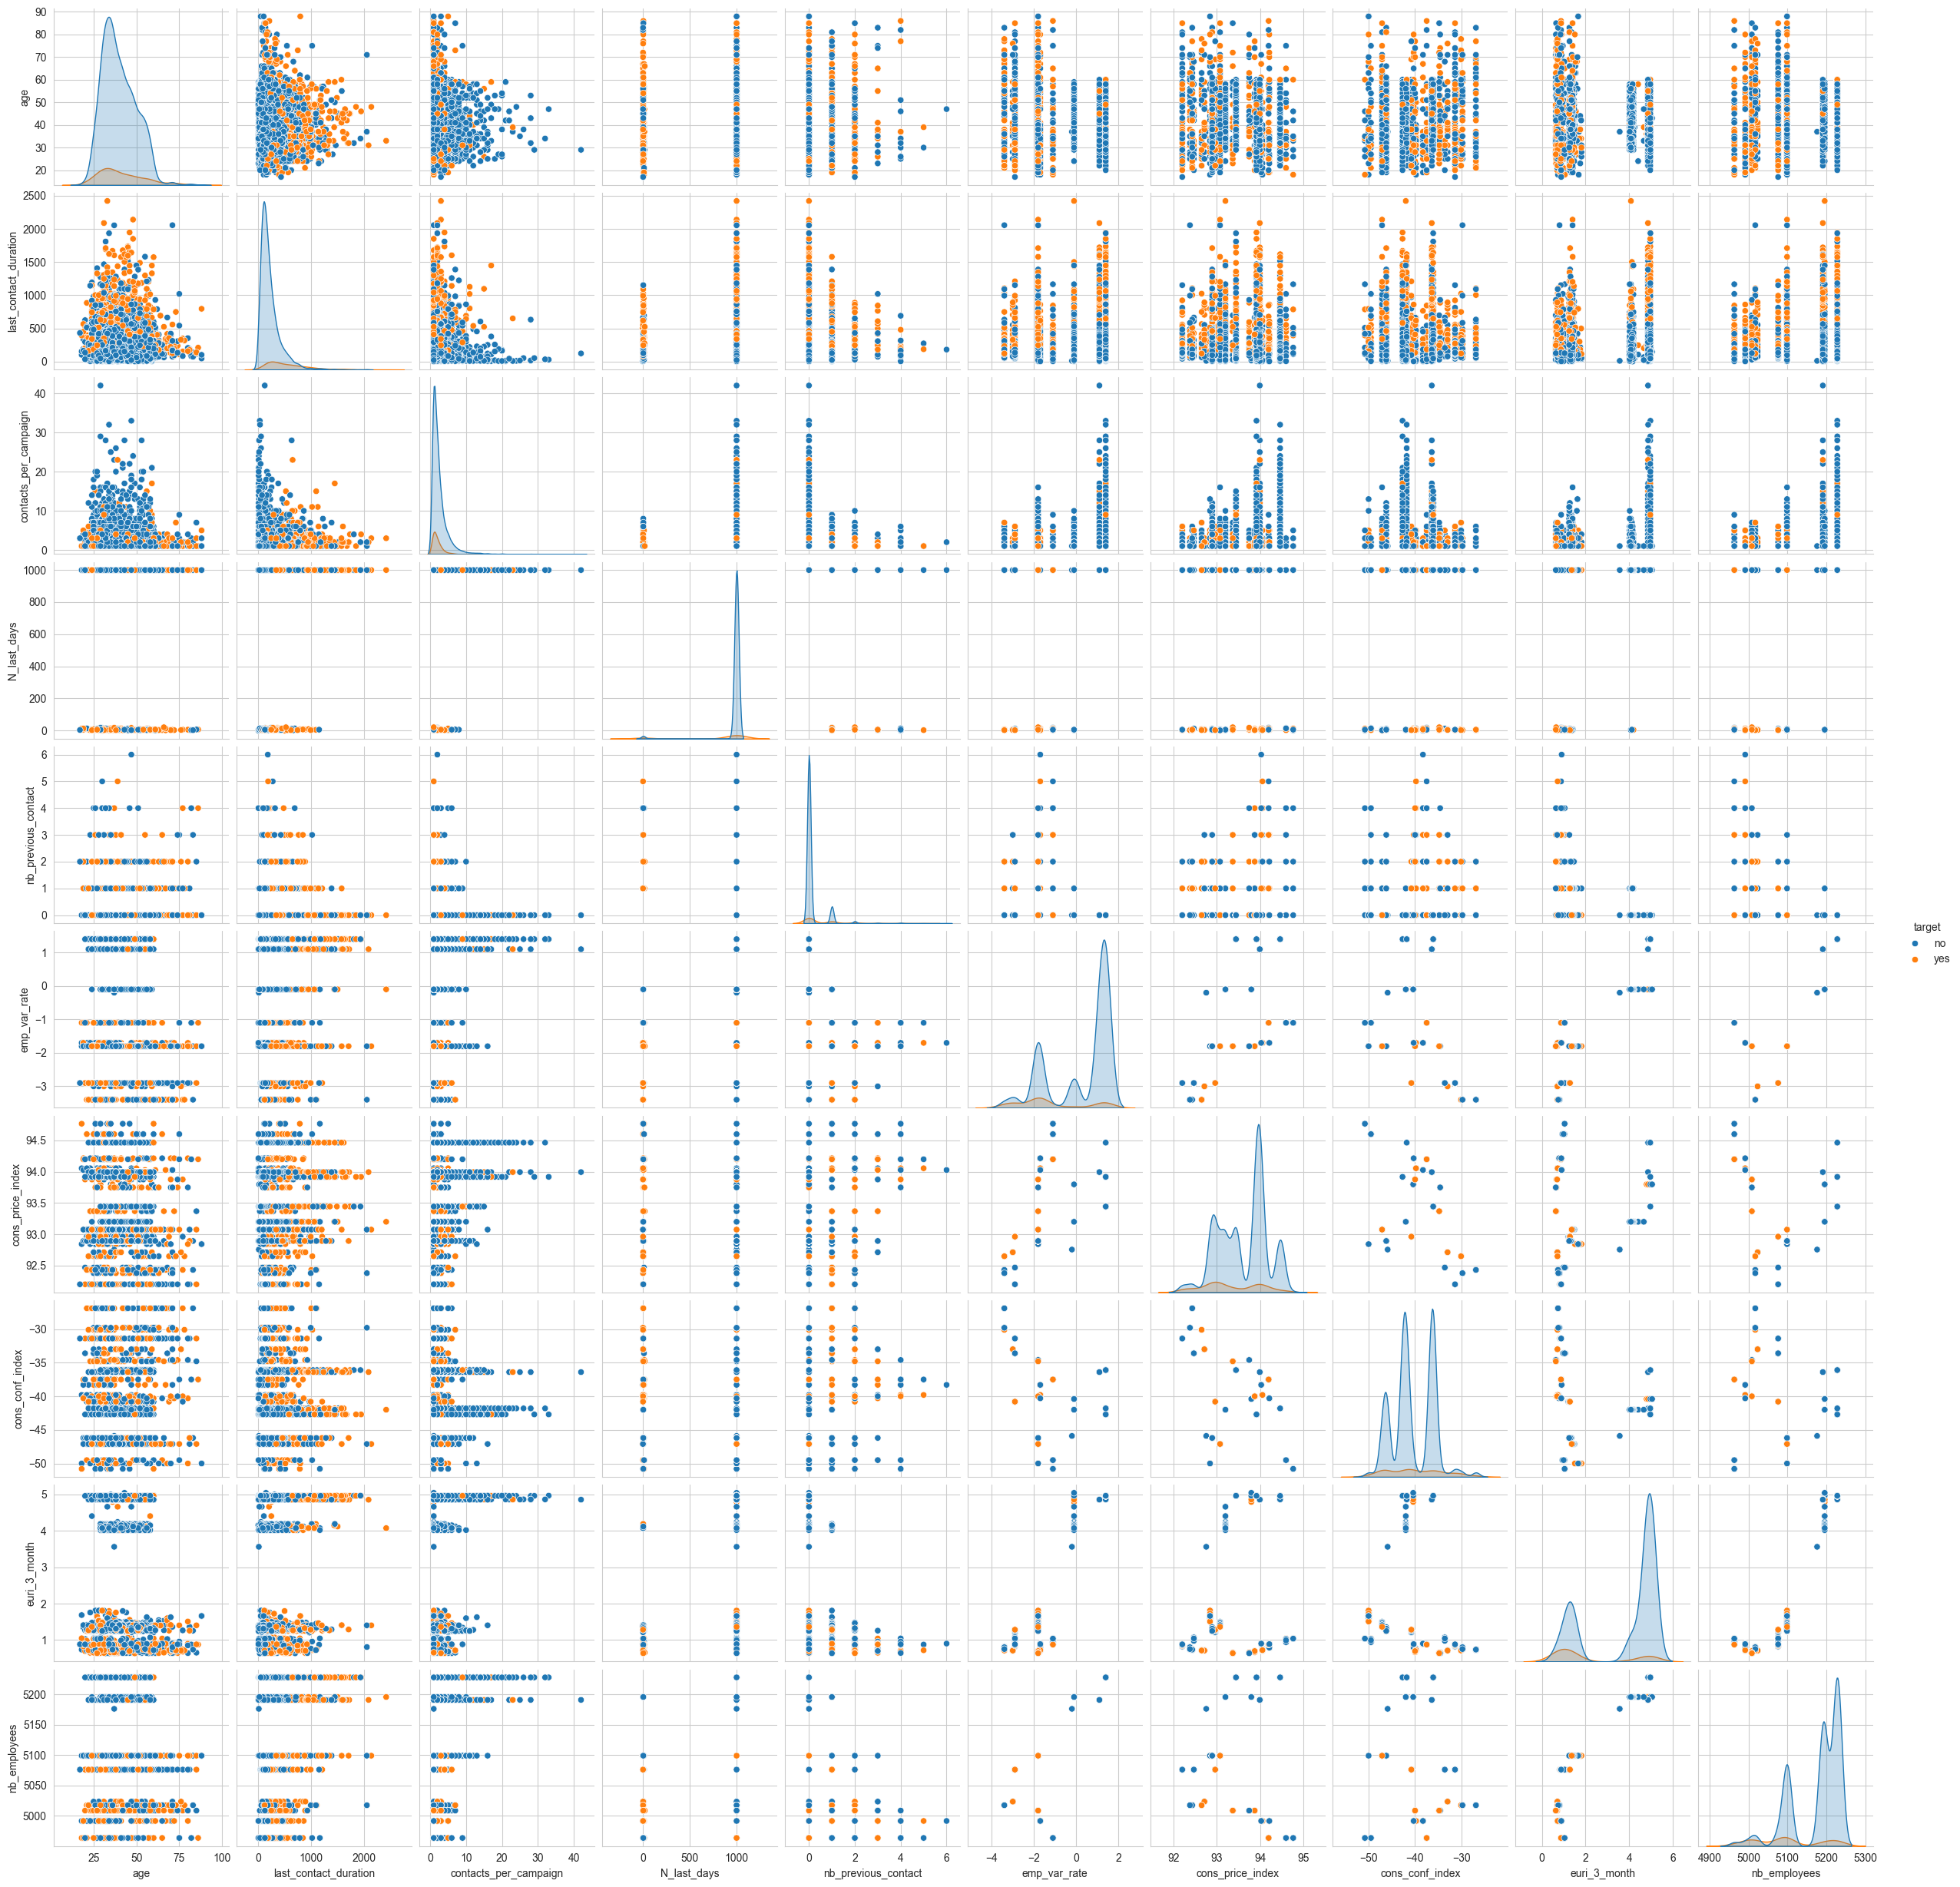

In [118]:
sns.pairplot(
    df[
        df.select_dtypes(include=["int64", "float64"]).columns.tolist() + ["target"]
    ].sample(n=5000, random_state=42),
    hue="target",
    diag_kind="kde",
)

In [119]:
# N_last_days = 999 means that the customer has no previous contacts
df[df["N_last_days"] == 999].stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
N_last_days,39673,1,999,39673,999,39673
target,39673,2,no,36000,yes,3673
contact_mode,39673,2,cellular,24742,telephone,14931
previous_outcome,39673,2,nonexistent,35563,failure,4110
has_credit,39673,3,no,31137,yes,3
housing_loan,39673,3,yes,20741,unknown,956
personal_loan,39673,3,no,32699,unknown,956
marital_status,39673,4,married,24131,unknown,75
week_day,39673,5,thu,8280,fri,7581
nb_previous_contact,39673,7,0,35563,6,1


In [120]:
# Add new features
df = add_engineered_features(df)

In [121]:
# Delete useless features
df = df.drop(columns=["has_credit", "nb_previous_contact", "cons_conf_index", "N_last_days", "emp_var_rate", "nb_employees"])

#### Final dataframe

In [122]:
df.head()

,age,occupation,marital_status,education,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,...,target,age_group,education_marital,interest_diff,month_weekday,interest_pressure_ratio,log_duration,season,loan_burden_score,volatility_score
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,...,no,senior,basic.4y_married,89.137,may_mon,19.348291,5.568345,spring,0,42.357
1,57,services,married,high.school,no,no,telephone,may,mon,149,...,no,senior,high.school_married,89.137,may_mon,19.348291,5.010635,spring,0,42.357
2,37,services,married,high.school,yes,no,telephone,may,mon,226,...,no,middle,high.school_married,89.137,may_mon,19.348291,5.424950,spring,1,42.357
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,...,no,middle,basic.6y_married,89.137,may_mon,19.348291,5.023881,spring,0,42.357
4,56,services,married,high.school,no,yes,telephone,may,mon,307,...,no,senior,high.school_married,89.137,may_mon,19.348291,5.730100,spring,1,42.357


In [123]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
target,41188,2,no,36548,yes,4640
contact_mode,41188,2,cellular,26144,telephone,15044
previous_outcome,41188,3,nonexistent,35563,success,1373
loan_burden_score,41188,3,1,20442,2,3691
housing_loan,41188,3,yes,21576,unknown,990
personal_loan,41188,3,no,33950,unknown,990
age_group,41188,3,middle,30223,senior,3582
marital_status,41188,4,married,24928,unknown,80
season,41188,4,summer,18670,winter,182
week_day,41188,5,thu,8623,fri,7827


In [124]:
# sns.pairplot(
#     df[df.select_dtypes(include=["int64", "float64"]).columns.tolist() + ["target"]].sample(n=10000, random_state=42),
#     hue="target",
#     diag_kind="kde",
# )

### Modeling

In [125]:
categorial_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
categorial_features

['occupation',
 'marital_status',
 'education',
 'housing_loan',
 'personal_loan',
 'contact_mode',
 'month',
 'week_day',
 'previous_outcome',
 'target',
 'age_group',
 'education_marital',
 'month_weekday',
 'season']

In [126]:
categorial_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
categorial_features.remove("target")
categorial_features.extend(
    [
        "age_group",
        "education_marital",
        "month_weekday",
        "loan_burden_score"
    ]
)

In [127]:
target_dict = {"yes": 1, "no": 0}
df.loc[:, "target"] = df["target"].map(target_dict)
df.loc[:, "target"] = df.astype("category")

In [128]:
y = df.pop("target")
y = y.astype(int)

In [129]:
df.head()

,age,occupation,marital_status,education,housing_loan,personal_loan,contact_mode,month,week_day,last_contact_duration,...,euri_3_month,age_group,education_marital,interest_diff,month_weekday,interest_pressure_ratio,log_duration,season,loan_burden_score,volatility_score
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,...,4.857,senior,basic.4y_married,89.137,may_mon,19.348291,5.568345,spring,0,42.357
1,57,services,married,high.school,no,no,telephone,may,mon,149,...,4.857,senior,high.school_married,89.137,may_mon,19.348291,5.010635,spring,0,42.357
2,37,services,married,high.school,yes,no,telephone,may,mon,226,...,4.857,middle,high.school_married,89.137,may_mon,19.348291,5.424950,spring,1,42.357
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,...,4.857,middle,basic.6y_married,89.137,may_mon,19.348291,5.023881,spring,0,42.357
4,56,services,married,high.school,no,yes,telephone,may,mon,307,...,4.857,senior,high.school_married,89.137,may_mon,19.348291,5.730100,spring,1,42.357


In [130]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    df, y, val_size=0.1, test_size=0.2, use_stratification=True, random_state=42
)

In [131]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

In [132]:
y_val.value_counts(normalize=True)

target
0    0.887351
1    0.112649
Name: proportion, dtype: float64

In [133]:
y_train_full.value_counts(normalize=True)

target
0    0.887344
1    0.112656
Name: proportion, dtype: float64

In [134]:
y_train_full.info()

<class 'pandas.core.series.Series'>
Index: 32950 entries, 37802 to 8127
Series name: target
Non-Null Count  Dtype
--------------  -----
32950 non-null  int64
dtypes: int64(1)
memory usage: 514.8 KB


In [135]:
classes = np.unique(y_train_full)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train_full
)
class_weights = class_weights.tolist()
class_weights

[0.5634790341336616, 4.438308189655173]

In [136]:
def optimize_catboost(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    n_repeats: Optional[int] = None,
    n_trials: int = 50,
    random_state: int = 42,
    max_iterations: int = 1000,
    optimize_metric: Literal["F1", "Recall"] = "F1",
) -> Tuple[optuna.Study, Dict[str, Any], pd.DataFrame]:
    """
    Optimize CatBoost hyperparameters for imbalanced classification, including class_weights,
    using StratifiedKFold/RepeatedStratifiedKFold and Optuna.
    """

    import warnings

    warnings.filterwarnings("ignore", category=UserWarning)

    if optimize_metric not in ["F1", "Recall"]:
        raise ValueError("optimize_metric must be either 'F1' or 'Recall'.")

    # assert not y.isnull().any(), "Target y contains NaN values."

    def objective(trial: optuna.Trial) -> float:
        """Objective function to optimize."""
        params = {
            "loss_function": "Logloss",
            "eval_metric": optimize_metric,
            "custom_metric": ["Logloss"],
            "iterations": max_iterations,
            "use_best_model": False,
            "metric_period": 1,
            "depth": trial.suggest_int("depth", 3, 14),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.4, log=True),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
            "random_strength": trial.suggest_float(
                "random_strength", 1e-2, 10.0, log=True
            ),
            "border_count": trial.suggest_int("border_count", 32, 256),
            "auto_class_weights": "Balanced",
            "verbose": 0,
            "random_seed": random_state,
            "allow_writing_files": False,
        }

        if n_repeats:
            skf = RepeatedStratifiedKFold(
                n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
            )
        else:
            skf = StratifiedKFold(
                n_splits=n_splits, shuffle=True, random_state=random_state
            )

        scoring_func = recall_score if optimize_metric == "Recall" else f1_score

        fold_scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**params, cat_features=categorial_features)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))

            y_pred = model.predict(X_val)
            fold_scores.append(scoring_func(y_val, y_pred, pos_label=1))

        return np.mean(fold_scores)

    # Create and configure Optuna study
    study = optuna.create_study(direction="maximize")

    # Entry point for optimization
    study.enqueue_trial(
        {
            'depth': 14,
            'learning_rate': 0.010864262063763354,
            'l2_leaf_reg': 6,
            'random_strength': 2.1957899361410305,
            'border_count': 216
        }
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_trial.params

    # Merge static params back
    fixed_params = {
        "loss_function": "Logloss",
        "eval_metric": optimize_metric,
        "custom_metric": ["Logloss"],
        "iterations": max_iterations,
        "use_best_model": False,
        "metric_period": 1,
        "verbose": 0,
        "random_seed": random_state,
        "allow_writing_files": False,
    }

    best_params.update(fixed_params)

    # Final CV pass
    def cross_val_iterations(
        X: pd.DataFrame,
        y: pd.Series,
        params: Dict[str, Any],
        n_splits: int,
        n_repeats: Optional[int],
        random_state: int,
        main_metric: str,
    ) -> pd.DataFrame:
        """Manual CV to gather iteration-wise statistics."""
        if n_repeats:
            skf = RepeatedStratifiedKFold(
                n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
            )
        else:
            skf = StratifiedKFold(
                n_splits=n_splits, shuffle=True, random_state=random_state
            )

        train_metric_folds, test_metric_folds = [], []
        train_logloss_folds, test_logloss_folds = [], []

        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**params, cat_features=categorial_features)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))

            results = model.get_evals_result()
            train_key, test_key = "learn", "validation"
            if test_key not in results:
                # older catboost versions might store "eval"
                test_key = "eval"

            # The main metric might be "F1" or "Recall", custom metric is "Logloss"
            # Example: results["learn"]["F1"] or results["learn"]["Recall"]
            train_metric_folds.append(results[train_key][main_metric])
            test_metric_folds.append(results[test_key][main_metric])

            # If "Logloss" not found, fallback to "TotalLoss"
            if "Logloss" in results[train_key]:
                train_logloss_folds.append(results[train_key]["Logloss"])
                test_logloss_folds.append(results[test_key]["Logloss"])
            else:
                train_logloss_folds.append(results[train_key]["TotalLoss"])
                test_logloss_folds.append(results[test_key]["TotalLoss"])

        n_iters = len(train_metric_folds[0])

        data = []
        for i in range(n_iters):
            data.append(
                {
                    "iteration": i + 1,
                    f"train-{main_metric}-mean": np.mean(
                        [fold[i] for fold in train_metric_folds]
                    ),
                    f"train-{main_metric}-std": np.std(
                        [fold[i] for fold in train_metric_folds], ddof=1
                    ),
                    f"test-{main_metric}-mean": np.mean(
                        [fold[i] for fold in test_metric_folds]
                    ),
                    f"test-{main_metric}-std": np.std(
                        [fold[i] for fold in test_metric_folds], ddof=1
                    ),
                    "train-Logloss-mean": np.mean(
                        [fold[i] for fold in train_logloss_folds]
                    ),
                    "train-Logloss-std": np.std(
                        [fold[i] for fold in train_logloss_folds], ddof=1
                    ),
                    "test-Logloss-mean": np.mean(
                        [fold[i] for fold in test_logloss_folds]
                    ),
                    "test-Logloss-std": np.std(
                        [fold[i] for fold in test_logloss_folds], ddof=1
                    ),
                }
            )

        return pd.DataFrame(data)

    cv_results = cross_val_iterations(
        X, y, best_params, n_splits, n_repeats, random_state, optimize_metric
    )

    return study, best_params, cv_results

In [137]:
# # Optimize and retrieve iteration-wise CV results
# study_obj, best_params, cv_table = optimize_catboost(
#     X_train_full,
#     y_train_full,
#     optimize_metric="F1",
#     n_splits=3,
#     n_trials=10,
#     random_state=42,
#     max_iterations=2000,
# )

In [138]:
# # Print results
# print("Best F1:", study_obj.best_value)
#
# best_params["iterations"] = cv_table["test-F1-mean"].idxmax()
# print("Best parameters:", best_params)

In [139]:
best_params = {
    'depth': 14,
    'learning_rate': 0.010864262063763354,
    'l2_leaf_reg': 6,
    'random_strength': 2.1957899361410305,
    'border_count': 216,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'custom_metric': ['Logloss'],
    'iterations': 1501
}

In [140]:
model = CatBoostClassifier(
    cat_features=categorial_features,
    loss_function=best_params["loss_function"],
    eval_metric=best_params["eval_metric"],
    iterations=best_params["iterations"],
    depth=best_params["depth"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    random_strength=best_params["random_strength"],
    border_count=best_params["border_count"],
    auto_class_weights="Balanced",
    random_seed=42,
)

In [141]:
model.fit(X_train_full, y_train_full)

0:	learn: 0.8735532	total: 305ms	remaining: 7m 36s
1:	learn: 0.8724910	total: 344ms	remaining: 4m 17s
2:	learn: 0.8736461	total: 396ms	remaining: 3m 17s
3:	learn: 0.8772856	total: 458ms	remaining: 2m 51s
4:	learn: 0.8785742	total: 481ms	remaining: 2m 23s
5:	learn: 0.8763799	total: 498ms	remaining: 2m 4s
6:	learn: 0.8772126	total: 516ms	remaining: 1m 50s
7:	learn: 0.8768506	total: 537ms	remaining: 1m 40s
8:	learn: 0.8779375	total: 558ms	remaining: 1m 32s
9:	learn: 0.8793380	total: 799ms	remaining: 1m 59s
10:	learn: 0.8788830	total: 816ms	remaining: 1m 50s
11:	learn: 0.8781419	total: 855ms	remaining: 1m 46s
12:	learn: 0.8790579	total: 942ms	remaining: 1m 47s
13:	learn: 0.8786399	total: 1s	remaining: 1m 46s
14:	learn: 0.8791520	total: 1.24s	remaining: 2m 3s
15:	learn: 0.8783972	total: 1.27s	remaining: 1m 57s
16:	learn: 0.8802120	total: 1.33s	remaining: 1m 56s
17:	learn: 0.8815472	total: 1.58s	remaining: 2m 9s
18:	learn: 0.8808064	total: 1.59s	remaining: 2m 4s
19:	learn: 0.8804358	total: 1

In [142]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

In [143]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7310
           1       0.51      0.90      0.65       928

    accuracy                           0.89      8238
   macro avg       0.75      0.89      0.80      8238
weighted avg       0.93      0.89      0.90      8238



In [144]:
confusion_matrix(y_test, pred)

array([[6526,  784],
       [  97,  831]])

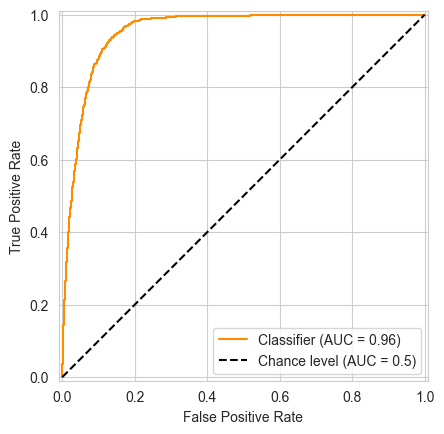

In [145]:
display = RocCurveDisplay.from_predictions(
    y_test,
    pred_proba,
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate")

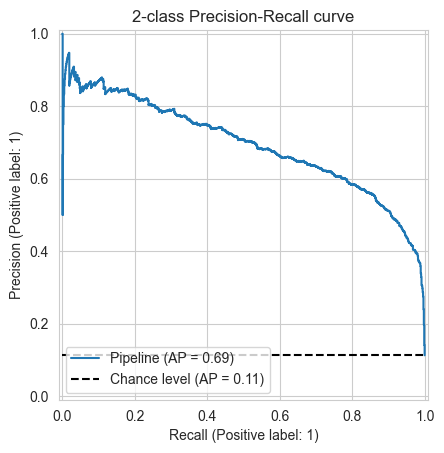

In [146]:
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="Pipeline", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

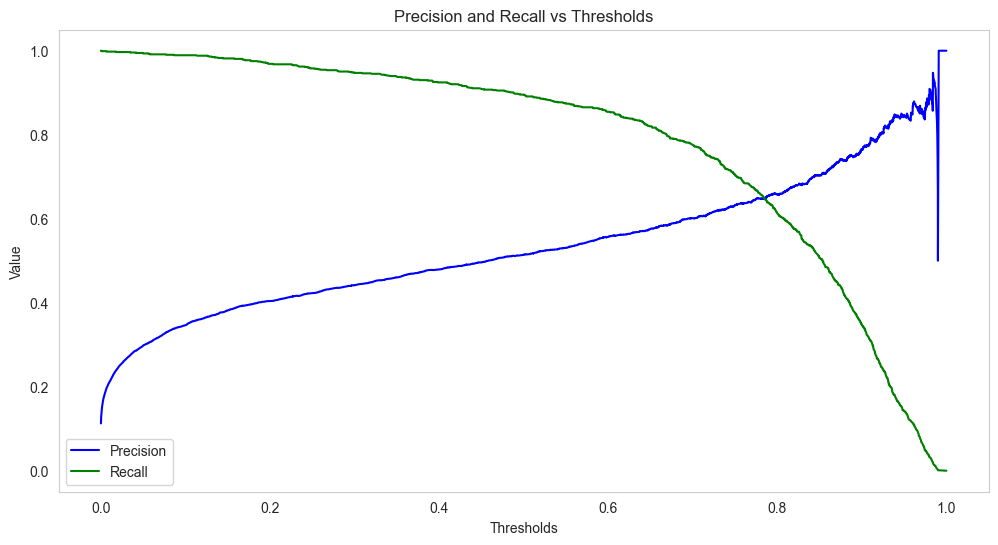

In [147]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")

plt.xlabel("Thresholds")
plt.ylabel("Value")
plt.title("Precision and Recall vs Thresholds")
plt.legend()
plt.grid()
plt.show()

### Find optimal threshold

In [148]:
def optimize_threshold_for_precision(y_true: np.ndarray, y_proba: np.ndarray, min_recall: float = 0.9) -> dict:
    """
    Find the threshold that gives max precision under recall ≥ min_recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Trim precision/recall to match thresholds (skip first point)
    precision, recall = precision[1:], recall[1:]

    # Find valid thresholds with recall ≥ min_recall
    valid = recall >= min_recall
    if not np.any(valid):
        raise ValueError(f"No threshold satisfies recall ≥ {min_recall}")

    best_idx = np.argmax(precision[valid])
    threshold = thresholds[valid][best_idx]

    y_pred = (y_proba >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        "best_threshold": threshold,
        "precision": precision[valid][best_idx],
        "recall": recall[valid][best_idx],
        "f1": report["1"]["f1-score"],
        "y_pred": y_pred,
        "report": report,
    }

In [149]:
# y_proba = model.predict_proba(X_test)[:, 1]
# result = optimize_threshold_for_precision(y_test, y_proba, min_recall=0.9)
# print(f"Best threshold: {result['best_threshold']:.3f}")
# print(f"Precision: {result['precision']:.3f}, Recall: {result['recall']:.3f}, F1: {result['f1']:.3f}")

In [150]:
# pred = (y_proba > result["best_threshold"]).astype(int)

In [151]:
# print(classification_report(y_test, pred))

### Feature importance

Calculating permutation importance using 'f1'...

Permutation Importance (based on validation set performance):
                    feature  importance_mean  importance_std
19             log_duration         0.091910        0.005969
9     last_contact_duration         0.085976        0.010215
1                occupation         0.031426        0.004356
16            interest_diff         0.028574        0.004586
10    contacts_per_campaign         0.024019        0.003268
22         volatility_score         0.023216        0.002099
17            month_weekday         0.019038        0.002659
3                 education         0.018261        0.003185
7                     month         0.017992        0.003522
11         previous_outcome         0.017454        0.002333
15        education_marital         0.016887        0.002509
0                       age         0.016568        0.002545
18  interest_pressure_ratio         0.013281        0.003831
14                age_group       

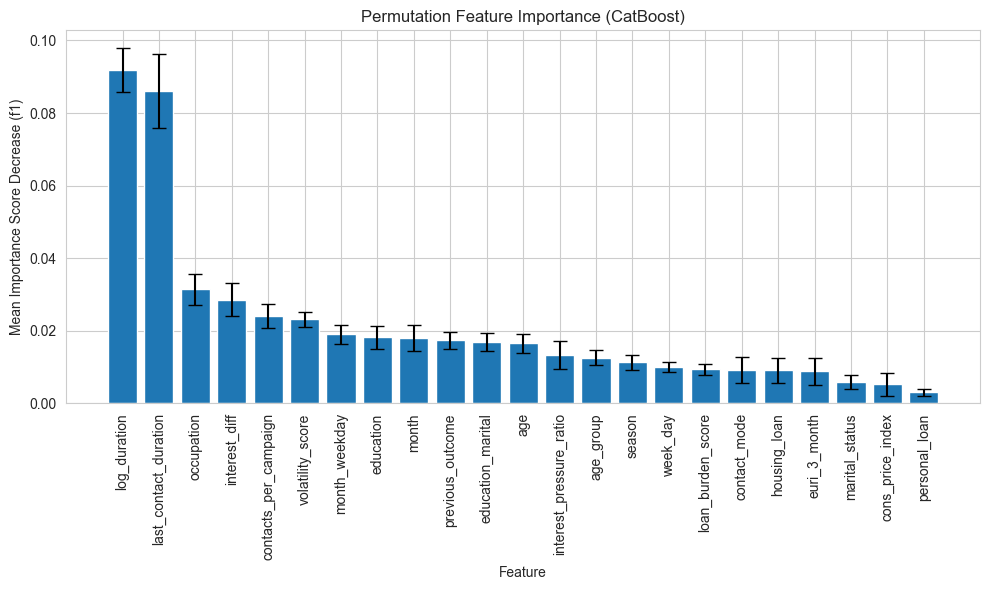

In [152]:
scoring_metric = 'f1'

print(f"Calculating permutation importance using '{scoring_metric}'...")
result = permutation_importance(
    estimator=model,        # The fitted CatBoost model
    X=X_val,                # Data to evaluate on (validation/test)
    y=y_val,                # True labels for the evaluation data
    scoring=scoring_metric, # Metric to evaluate performance drop
    n_repeats=10,           # Number of times to permute each feature
    random_state=42,
    n_jobs=-1               # Use all available CPU cores
)

# 5. Process and Display Results
importances_mean = result.importances_mean
importances_std = result.importances_std
feature_names = X_val.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': importances_mean,
    'importance_std': importances_std
}).sort_values(by='importance_mean', ascending=False)

print("\nPermutation Importance (based on validation set performance):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance_mean'],
        yerr=importance_df['importance_std'], capsize=5)
plt.xlabel("Feature")
plt.ylabel(f"Mean Importance Score Decrease ({scoring_metric})")
plt.title("Permutation Feature Importance (CatBoost)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Save model

In [153]:
model.save_model("catboost_model.cbm")